In [1]:
import torch
import torchvision
from torch import nn
from torchvision import models
from kornia.geometry import conversions
import argparse
from PIL import Image
import torch.nn.functional as F
import torch.nn.init
from torchvision import transforms
from PoseNetEff import PoseNet
import os
import numpy as np
from PIL import Image
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import transforms
from kornia.geometry import conversions
from kornia.geometry.conversions import QuaternionCoeffOrder as Order
import matplotlib.pyplot as plt
import matplotlib
from torch import optim

In [2]:
## Dataset ##

class LabDataset(Dataset):
    """Lab Dataset.

    Attributes:
        imgs (torch.Tensor): Images.
        poses (torch.Tensor): Camera poses.
    """

    def __init__(self, path, transform, train=True):
        """
        Args:
            path (str): Path of Lab dataset.
            train (bool): If True, return training data; else, return testing data.
            transform (torchvision.transforms): Image transform.
        """
        dir_path = path

        if train:
            split_path = os.path.join(dir_path, 'training_set')
        else:
            split_path = os.path.join(dir_path, 'testing_set')

        total_frames = int(len(os.listdir(split_path))/2)
        all_list = os.listdir(split_path)
        img_list = []
        for file in all_list:
            if(file.split('.')[-1] != "txt"):
                img_list.append(file + "")
                
        first_img_dir = img_list[0]
        img_temp = Image.open(os.path.join(split_path, first_img_dir)) 
        print(img_temp)
        img_temp = transform(img_temp)
        print(img_temp)
        height, width = img_temp.shape[-2:]
        self.imgs = torch.empty(total_frames, 3, height, width)
        self.poses = torch.empty(total_frames, 7)

        index = 0
        for file in img_list:
            img_path = os.path.join(split_path, file)
            img = Image.open(img_path)
            img = transform(img)
            self.imgs[index] = img
            pose_txt_path = os.path.join(split_path, f"{file.split('.')[0]}.txt")
            T = np.loadtxt(pose_txt_path, dtype='float32') # homogeneous transformation matrix, camera to world
            R = torch.tensor(T[:3, :3]) # rotation matrix
            r = torch.tensor(T[:3, 3]) # translation vector
            q = conversions.rotation_matrix_to_quaternion(R, order=Order.WXYZ) # quaternion
            if q[0] < 0:
                q = -q # constrain q0 > 0
            pose = torch.hstack((r, q))
            self.poses[index] = pose
            index += 1

    def __len__(self):
        return self.imgs.shape[0]

    def __getitem__(self, idx):
        """
        Args:
            idx (int): Input index.

        Returns:
            {'image' (torch.Tensor): Image,
             'pose' (torch.Tensor): Pose of the image.}

        Shape:
            {'image': (3, height, width),
             'pose': (7).}
        """
        return {'image': self.imgs[idx],
                'pose': self.poses[idx]}

In [3]:
## Lose ##

class PoseLoss(nn.Module):
    """Camera pose loss (PoseNet17)."""

    def __init__(self, s_x=0.0, s_q=-3.0, device=torch.device('cpu')):
        """
        Args:
            s_x, s_q (float): Initial value of s_x, s_q.
            device (torch.device): The device on which tensor will be allocated.
        """
        super().__init__()
        self.s_x = nn.Parameter(torch.tensor(s_x, device=device))
        self.s_q = nn.Parameter(torch.tensor(s_q, device=device))

    def forward(self, pred, targ):
        """
        Args:
            pred (torch.Tensor): Predicted camera poses.
            targ (torch.Tensor): Target camera poses.

        Returns:
            loss (torch.Tensor): Loss value.

        Shape:
            pred: (batch_size, 7).
            targ: (batch_size, 7).
            loss: (1).
        """
        l1_loss = nn.L1Loss()
        loss = (l1_loss(pred[:, :3], targ[:, :3]) * torch.exp(-self.s_x) + self.s_x +
                l1_loss(pred[:, 3:], targ[:, 3:]) * torch.exp(-self.s_q) + self.s_q)
        return loss

In [4]:
## Utils ##

def cal_quaternion_angular_error(q_pred, q_targ):
    """Calculate quaternion angular error.

    Relative pose of q_pred and q_targ: q_pred^-1 * q_targ = q_pred* * q_targ.
    Quaternion angular error: 2 * cos^-1(s),
                              s = q_pred_0 * q_targ_0 + q_pred_1 * q_targ_1 +
                                  q_pred_2 * q_targ_2 + q_pred_3 * q_targ_3.

    Args:
        q_pred (torch.Tensor): Predicted quaternions.
        q_targ (torch.Tensor): Target quaternions.

    Returns:
        theta (torch.Tensor): Quaternion angular errors.

    Shape:
        q_pred: (batch_size, 4).
        q_targ: (batch_size, 4).
        theta: (batch_size).
    """
    s = torch.sum(q_pred*q_targ, dim=1)
    theta = 2 * torch.acos(s) * 180 / np.pi
    return theta

def denormalize(images, mean, std):
    """Denormalize images.

    Args:
        images (torch.Tensor): Input Images.
        mean (list): RGB mean.
        std (list): RGB standard deviation.

    Returns:
        images (torch.Tensor): Output Images.

    Shape:
        images (input): (batch_size, channel, height, width).
        mean: (channel).
        std: (channel).
        images (output): (batch_size, channel, height, width).
    """
    device = images.device
    mean = torch.tensor(mean, device=device)
    std = torch.tensor(std, device=device)
    images = images.permute(0, 2, 3, 1) # (batch_size, height, width, channel)
    images = images * std + mean
    images = images.permute(0, 3, 1, 2) # (batch_size, channel, height, width)
    return images

def print_loss(iteration, total_iterations, loss, loss_name='loss'):
    """Clean the line and print the loss.

    Args:
        iteration (int): This iteration.
        total_iterations (int): Total iterations.
        loss (number): Loss value.
        loss_name (str): Loss name.
    """
    string = f'{iteration}/{total_iterations} - {loss_name}: {loss:.4f}'
    space = '                              '
    print(f'\r{space}', end='\r')
    if iteration != total_iterations:
        print(string, end='', flush=True)
    else:
        print(string)

def output_loss(output_name, loss_history, loss_name='loss', loss_history2=[], loss_name2=''):
    """Output loss files and plots.

    Args:
        output_name (str): Output name.
        loss_history (numpy.ndarray): Loss history.
        loss_name (str): Loss name.
    """
    np.savetxt(f'plots/{output_name}.{loss_name}.txt', loss_history)
    
    
    if loss_name != 'loss':
        plt.plot(loss_history, color='green', linewidth=0.7, label = 's_x')
        plt.plot(loss_history2, color='red', linewidth=0.7, label = 's_g')
        plt.ylabel('units')
    else:
        plt.ylabel(loss_name)
        plt.ylim([-15,25])
        plt.plot(loss_history, color='blue', linewidth=0.7, label = 'loss')
        
    plt.legend(loc='upper right', shadow=True) 
    plt.xlabel('iteration')
    plt.savefig(f'plots/{output_name}.{loss_name}_{loss_name2}.png')
    plt.close()

In [5]:
## Training pre-settings ##
"""
Args:
    output_name (str): Name for output checkpoints, loss files and loss plots.
    path (str): Path of the dataset.
    resize (int): Resize the short edge of image to the given number.
    batch_size (int): Batch size.
    num_workers (int): How many subprocesses to use for data loading.
    pin_memory (bool): If True, the data loader will copy Tensors into CUDA pinned memory before returning them.
    lr (float): Learning rate.
    epochs (int): Training epochs.
    checkpoint_epochs (int): How many epochs to save a checkpoint.
    device (torch.device): The device on which tensor will be allocated.
"""
output_name = 'posenet_eff_b4_labdata_0518'
path = '../lab_data/datasets'
resize = 600
batch_size = 4
num_workers = 0
pin_memory = True
lr = 0.001
epochs = 500
checkpoint_epochs = 10 
device=torch.device('cuda')

mean = [0.4702,0.4557,0.4363] #calculated by get_datas_mean_std function
std = [0.2696,0.2698,0.2564]
transform = transforms.Compose([
    transforms.Resize(size=(resize,resize)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

In [6]:
## Create directory ##

if not os.path.isdir('checkpoints'):
    os.mkdir('checkpoints')
if not os.path.isdir('plots'):
    os.mkdir('plots')

In [7]:
## Load training data ##

trainset = LabDataset(path, transform=transform, train=True)
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True,
                          num_workers=num_workers, pin_memory=pin_memory,
                          drop_last=True)

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1920x1080 at 0x2A5D6DB2830>
tensor([[[ 0.9178,  0.9178,  0.9178,  ...,  1.3106,  1.3106,  1.3106],
         [ 0.9178,  0.9178,  0.9178,  ...,  1.3106,  1.3106,  1.3106],
         [ 0.9178,  0.9178,  0.9178,  ...,  1.3106,  1.3106,  1.3106],
         ...,
         [-0.8859, -0.1295,  0.0305,  ...,  0.1178,  0.1324,  0.1324],
         [-0.9731, -0.2022,  0.0596,  ...,  0.1178,  0.1033,  0.1033],
         [-1.0313, -0.2749,  0.0742,  ...,  0.1324,  0.1178,  0.1324]],

        [[ 0.9709,  0.9709,  0.9709,  ...,  1.3197,  1.3197,  1.3197],
         [ 0.9709,  0.9709,  0.9709,  ...,  1.3197,  1.3197,  1.3197],
         [ 0.9709,  0.9709,  0.9709,  ...,  1.3197,  1.3197,  1.3197],
         ...,
         [-0.8024, -0.0466,  0.1133,  ...,  0.1860,  0.2005,  0.2005],
         [-0.8896, -0.1192,  0.1424,  ...,  0.1860,  0.1715,  0.1715],
         [-0.9477, -0.1919,  0.1569,  ...,  0.2005,  0.1860,  0.2005]],

        [[ 1.0973,  1.0973,  1.09

In [8]:
## Load model ##

posenet = PoseNet(droprate=0.5, device=device)
posenet = posenet.to(device)

In [9]:
## Training settings ##

criterion = PoseLoss(s_x=0.0, s_q=-3.0, device=device)
params = list(posenet.parameters()) + list(criterion.parameters())
optimizer = optim.Adam(params, lr=lr)

In [10]:
## Training Step ##

loss_history = []
loss_pt = []
s_history = []

print(f'Start training {output_name}...')
for i in range(epochs):
    print(f'Epoch {i+1}/{epochs}')
    for j, data in enumerate(trainloader):
        inputs = data['image'].to(device)
        poses = data['pose'].to(device)

        optimizer.zero_grad()
        outputs = posenet(inputs)
        loss = criterion(outputs, poses)
        loss.backward()
        optimizer.step()

        loss_history.append(loss.item())
        s_history.append([criterion.s_x.item(), criterion.s_q.item()])
        print_loss(j+1, len(trainloader), loss)

    # Save checkpoint

    if (i+1)%checkpoint_epochs == 0:
        loss_pt.append(loss.item())
        torch.save({
            'model': posenet.state_dict(),
            'optimizer': optimizer.state_dict()
        }, f'checkpoints/{output_name}.pt-{i+1}')

Start training posenet_eff_b4_labdata_0518...
Epoch 1/500
350/350 - loss: 6.0152        
Epoch 2/500
350/350 - loss: 3.3173        
Epoch 3/500
350/350 - loss: 1.5566        
Epoch 4/500
350/350 - loss: 2.8337        
Epoch 5/500
350/350 - loss: 2.2380        
Epoch 6/500
350/350 - loss: 2.4153        
Epoch 7/500
350/350 - loss: 2.3955        
Epoch 8/500
350/350 - loss: 1.7262        
Epoch 9/500
350/350 - loss: 1.5692        
Epoch 10/500
350/350 - loss: 1.4218        
Epoch 11/500
350/350 - loss: 1.6767        
Epoch 12/500
350/350 - loss: 1.7248        
Epoch 13/500
350/350 - loss: 1.8825        
Epoch 14/500
350/350 - loss: 1.8674        
Epoch 15/500
350/350 - loss: 1.3835        
Epoch 16/500
350/350 - loss: 1.7720        
Epoch 17/500
350/350 - loss: 1.9114        
Epoch 18/500
350/350 - loss: 2.1031        
Epoch 19/500
350/350 - loss: 1.2371        
Epoch 20/500
350/350 - loss: 1.3542        
Epoch 21/500
350/350 - loss: 2.3928        
Epoch 22/500
350/350 - loss: 1.4275    

350/350 - loss: 0.3133        
Epoch 185/500
350/350 - loss: 1.3545        
Epoch 186/500
350/350 - loss: 1.0059        
Epoch 187/500
350/350 - loss: 1.2769        
Epoch 188/500
350/350 - loss: 0.7992        
Epoch 189/500
350/350 - loss: 1.5048        
Epoch 190/500
350/350 - loss: 0.6649        
Epoch 191/500
350/350 - loss: 0.9789        
Epoch 192/500
350/350 - loss: 1.3916        
Epoch 193/500
350/350 - loss: 1.1695        
Epoch 194/500
350/350 - loss: 0.4997        
Epoch 195/500
350/350 - loss: 0.7866        
Epoch 196/500
350/350 - loss: -0.3181       
Epoch 197/500
350/350 - loss: 0.5343        
Epoch 198/500
350/350 - loss: 0.8010        
Epoch 199/500
350/350 - loss: 0.5976        
Epoch 200/500
350/350 - loss: 0.9475        
Epoch 201/500
350/350 - loss: 0.1971        
Epoch 202/500
350/350 - loss: 0.1527        
Epoch 203/500
350/350 - loss: -0.0862       
Epoch 204/500
350/350 - loss: -0.1533       
Epoch 205/500
350/350 - loss: 0.0184        
Epoch 206/500
350/350 - 

350/350 - loss: -1.8936       
Epoch 367/500
350/350 - loss: -0.6798       
Epoch 368/500
350/350 - loss: -0.0109       
Epoch 369/500
350/350 - loss: 0.8608        
Epoch 370/500
350/350 - loss: -1.8718       
Epoch 371/500
350/350 - loss: -2.0281       
Epoch 372/500
350/350 - loss: 0.4797        
Epoch 373/500
350/350 - loss: -1.6039       
Epoch 374/500
350/350 - loss: -1.8667       
Epoch 375/500
350/350 - loss: -1.8335       
Epoch 376/500
350/350 - loss: -1.7199       
Epoch 377/500
350/350 - loss: -1.9713       
Epoch 378/500
350/350 - loss: -0.7089       
Epoch 379/500
350/350 - loss: 2.1844        
Epoch 380/500
350/350 - loss: -0.9527       
Epoch 381/500
350/350 - loss: -1.8381       
Epoch 382/500
350/350 - loss: -0.6462       
Epoch 383/500
350/350 - loss: -0.1334       
Epoch 384/500
350/350 - loss: -0.5732       
Epoch 385/500
350/350 - loss: -1.9129       
Epoch 386/500
350/350 - loss: 0.1567        
Epoch 387/500
350/350 - loss: -1.2098       
Epoch 388/500
350/350 - 

In [11]:
## Output files ##

np.savetxt(f'checkpoints/{output_name}.loss_pt.txt', np.array(loss_pt))
output_loss(output_name, loss_history=np.array(loss_history))
output_loss(output_name,loss_history= np.array(s_history)[:, 0], loss_name='s_x', loss_history2=np.array(s_history)[:, 1], loss_name2='s_q')

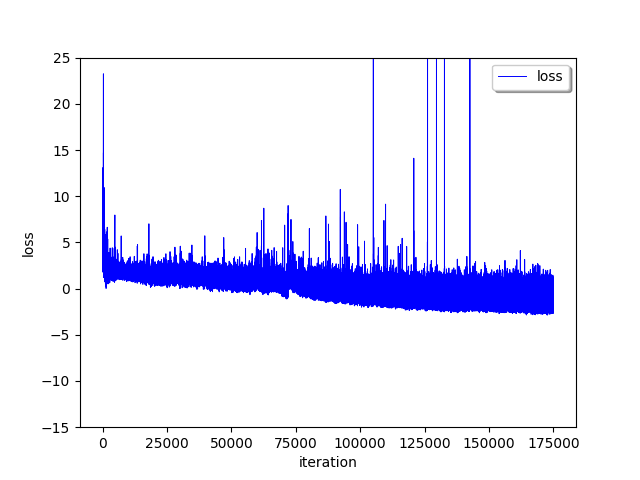

In [12]:
## Show loss plot ##

plot = Image.open(f'plots/{output_name}.loss_.png')
display(plot)

In [21]:
## Testing pre-settings ##

"""
Args:
    checkpoint_name (str): Checkpoint name.
    path (str): Path of the dataset.
    scene (str): Scene in the dataset.
    resize (int): Resize the short edge of image to the given number.
    num_workers (int): How many subprocesses to use for data loading.
    pin_memory (bool): If True, the data loader will copy Tensors into CUDA pinned memory before returning them.
    epochs (int): Training epochs.
    checkpoint_epochs (int): How many epochs to save a checkpoint.
    device (torch.device): The device on which tensor will be allocated.
"""
checkpoint_name = 'posenet_eff_b4_labdata_0518'
path = '../lab_data/datasets'
resize = 600
num_workers = 0
pin_memory = True
epochs = 500
checkpoint_epochs = 10 
device=torch.device('cuda')

mean = [0.4674, 0.4536, 0.4341] #calculated by get_datas_mean_std function
std = [0.2703, 0.2703, 0.2569]
transform = transforms.Compose([
    transforms.Resize(size=(resize,resize)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

In [19]:
## Create directory ##

if not os.path.isdir('results'):
    os.mkdir('results')

In [20]:
## Load testing data ##

testset = LabDataset(path, transform=transform, train=False)
testloader = DataLoader(testset, batch_size=1, shuffle=False,
                          num_workers=num_workers, pin_memory=pin_memory)

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1920x1080 at 0x2A779ED2470>
tensor([[[ 0.9548,  0.9693,  0.9693,  ...,  1.3175,  1.3175,  1.3175],
         [ 0.9548,  0.9693,  0.9693,  ...,  1.3175,  1.3175,  1.3175],
         [ 0.9548,  0.9548,  0.9693,  ...,  1.3175,  1.3175,  1.3175],
         ...,
         [-1.2504, -1.3665, -1.3955,  ...,  0.0843,  0.1134,  0.0988],
         [-1.1053, -1.2939, -1.3665,  ...,  0.0843,  0.1279,  0.1134],
         [-1.0763, -1.3085, -1.3665,  ...,  0.0843,  0.1134,  0.1134]],

        [[ 1.0204,  1.0349,  1.0349,  ...,  1.3251,  1.3251,  1.3251],
         [ 1.0204,  1.0349,  1.0349,  ...,  1.3251,  1.3251,  1.3251],
         [ 1.0204,  1.0204,  1.0349,  ...,  1.3251,  1.3251,  1.3251],
         ...,
         [-1.2284, -1.3444, -1.3735,  ...,  0.1064,  0.0919,  0.0919],
         [-1.0833, -1.2719, -1.3444,  ...,  0.1209,  0.1064,  0.1064],
         [-1.0543, -1.2864, -1.3444,  ...,  0.1209,  0.0919,  0.1064]],

        [[ 1.0732,  1.0885,  1.08

In [22]:
## Test all checkpoints ##

pme_list = []
ome_list = []
total_inference_time = 0
count_inference_time = 0

for epoch in range(0, epochs, checkpoint_epochs):

    # Load model

    posenet = PoseNet()
    posenet.to(device)
    pt = f'{checkpoint_name}.pt-{epoch+checkpoint_epochs}'
    checkpoint = torch.load(f'checkpoints/{pt}', map_location=device)
    posenet.load_state_dict(checkpoint['model'])
    posenet.eval()

    # Test

    position_errors = torch.empty(len(testset))
    orientation_errors = torch.empty(len(testset))
    print(f'Start testing {pt}...')
    poseL = 0
    outputL = 0
    with torch.no_grad():
        for i, data in enumerate(testloader):
            input = data['image'].to(device)
            pose = data['pose'].to(device)

            start_event = torch.cuda.Event(enable_timing=True)
            end_event = torch.cuda.Event(enable_timing=True)
            start_event.record()
            output = posenet(input)
            end_event.record()
            torch.cuda.synchronize() # wait for the events to be recorded
            inference_time = start_event.elapsed_time(end_event) # ms
            total_inference_time += inference_time
            count_inference_time += 1

            position_error = torch.linalg.norm(output[:, :3]-pose[:, :3], dim=1)
            position_errors[i] = position_error.cpu()
            orientation_error = cal_quaternion_angular_error(output[:, 3:], pose[:, 3:])
            orientation_errors[i] = orientation_error.cpu()
            poseL = pose
            outputL = output

    position_median_error = torch.median(position_errors)
    pme_list.append(position_median_error.item())
    orientation_median_error = torch.median(orientation_errors)
    ome_list.append(orientation_median_error.item())
    print(f'Median error = {position_median_error:.4f} m, {orientation_median_error:.4f} degree')
    print( outputL)
    print( poseL)
    

print()
print(f'Inference time = {total_inference_time/count_inference_time:.4f} ms')

Start testing posenet_eff_b4_labdata_0518.pt-10...
Median error = 4.8387 m, 101.3248 degree
tensor([[-0.6855,  1.5944,  1.8693,  0.1194,  0.8024,  0.0121,  0.5846]],
       device='cuda:0')
tensor([[-3.8584,  1.8433, -1.5826,  0.0810,  0.3881,  0.1288, -0.9090]],
       device='cuda:0')
Start testing posenet_eff_b4_labdata_0518.pt-20...
Median error = 5.4957 m, 108.3193 degree
tensor([[-0.9996,  1.4285, -0.6869,  0.0980,  0.7990,  0.0019,  0.5933]],
       device='cuda:0')
tensor([[-3.8584,  1.8433, -1.5826,  0.0810,  0.3881,  0.1288, -0.9090]],
       device='cuda:0')
Start testing posenet_eff_b4_labdata_0518.pt-30...
Median error = 5.1827 m, 118.1707 degree
tensor([[-2.4717,  0.3262, -2.7983,  0.1226,  0.9460,  0.0353,  0.2979]],
       device='cuda:0')
tensor([[-3.8584,  1.8433, -1.5826,  0.0810,  0.3881,  0.1288, -0.9090]],
       device='cuda:0')
Start testing posenet_eff_b4_labdata_0518.pt-40...
Median error = 5.1869 m, 103.8404 degree
tensor([[-1.4792,  1.8297, -1.2683,  0.0943,

Start testing posenet_eff_b4_labdata_0518.pt-290...
Median error = 3.2316 m, 35.0118 degree
tensor([[-2.4101,  1.4883, -2.7513,  0.0310,  0.4384,  0.0212, -0.8980]],
       device='cuda:0')
tensor([[-3.8584,  1.8433, -1.5826,  0.0810,  0.3881,  0.1288, -0.9090]],
       device='cuda:0')
Start testing posenet_eff_b4_labdata_0518.pt-300...
Median error = 4.6959 m, 68.3560 degree
tensor([[ 0.3616,  0.7944, -1.9420,  0.0192,  0.1271, -0.0044,  0.9917]],
       device='cuda:0')
tensor([[-3.8584,  1.8433, -1.5826,  0.0810,  0.3881,  0.1288, -0.9090]],
       device='cuda:0')
Start testing posenet_eff_b4_labdata_0518.pt-310...
Median error = 6.5235 m, 68.6890 degree
tensor([[ 2.1696, -2.3572, -0.6837,  0.0032, -0.0530, -0.0484,  0.9974]],
       device='cuda:0')
tensor([[-3.8584,  1.8433, -1.5826,  0.0810,  0.3881,  0.1288, -0.9090]],
       device='cuda:0')
Start testing posenet_eff_b4_labdata_0518.pt-320...
Median error = 7.3402 m, 30.0192 degree
tensor([[-9.8962,  2.1468, -1.3884,  0.0156,

In [23]:
## Output results ##

np.savetxt(f'results/{checkpoint_name}.pme.txt', pme_list)
np.savetxt(f'results/{checkpoint_name}.ome.txt', ome_list)